# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb\issues\7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [1]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import numpy as np
import pandas as pd
import pymupdf as PyMuPDF

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [4]:
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
len(documents)

1

In [5]:
print(documents[0][:100])


The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horow


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [6]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

373

Let's take a look at some of the documents we've managed to split.

In [7]:
split_documents[0:1]

['\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and wh

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [8]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?  

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
ANSWER: Yes - we can modify it by specifying the desired number of dimensions (an integer) for the parameter 'dimensions' to the API call. The resulting output embeddings will have the specified number of dimensions. 
</span>
</div>

2. What technique does OpenAI use to achieve this?  

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
ANSWER: OpenAI's new embedding models, text-embedding-3-small and text-embedding-3-large, utilize Matryoshka Representation Learning (MRL) to modify the dimensions of their embeddings. This technique allows for flexible and efficient dimension reduction while maintaining high performance.

MRL is implemented in two OpenAI's text embedding models - text-embedding-3-small and text-embedding-3-large models. This allows users to adjust embedding dimensions (e.g., from 1536 to as low as 512 for text-embedding-3-small) while preserving much of the semantic information.

</span>
</div>

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #2!

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [9]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?  

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
ANSWER: Sync approach follows a strict sequential process of executing commands, while async approach allows for concurrent execution of tasks, improving efficiency and responsiveness in many scenarios.  

Key benefits of async approach are:  

(1) Improved responsiveness / Fast performance while processing embeddings in the background,  

(2) Enhanced scalability by handling multiple embedding requests concurrently,  

(3) Efficient resource utilization optimizing system resource usage by allowing simultaneous operations, and  

(4) Better user experience due to no slowdowns during embedding generation
</span>
</div>

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [10]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=3)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?  

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
ANSWER: 
To ensure reproduciblity of outputs, we can do the following:  

(1) We can use a consistent seed for requests requiring reproducibility (similar to how we do it in machine learning). This feature is in beta / preview mode currently.  

(2) We should ensure all other parameters such as prompt, and temperature remain identical across requests.  

(3) We can also use system_fingerprint, a fingerptint of the backend configuration that the model is working with. Changes in this fingerprint value implies changes in backend potentially impact determinsm / output reproducibility. We should check the system fingerprint and regenerate outputs if it changes.  

However, it is critical to note that there's always a chance of differing responses even with same frozen parameters and system fingerprints due to inherent non-determinism of LLM outputs.
</span>
</div>

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

### Creating and Prompting OpenAI's `gpt-4o-mini`!

Let's tie all these together and use it to prompt `gpt-4o-mini`!

In [11]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [12]:
print(response)

The best way to write a loop in Python depends on your specific use case, but here are some general guidelines for writing clear and efficient loops:

1. **Use `for` Loop for Iterating Over Sequences**: If you want to iterate over a list, tuple, string, or any iterable, a `for` loop is typically the best choice.

   ```python
   items = [1, 2, 3, 4]
   for item in items:
       print(item)
   ```

2. **Use `while` Loop for Conditional Iteration**: If you want to loop until a certain condition is met, then a `while` loop is appropriate.

   ```python
   counter = 0
   while counter < 5:
       print(counter)
       counter += 1
   ```

3. **Be Mindful of Indentation**: Python uses indentation to define the scope of loops. Make sure your code is properly indented for readability.

4. **Avoid Infinite Loops**: Ensure that your condition for a `while` loop will eventually become false to avoid infinite loops.

5. **Consider Python’s Built-In Functions**: Functions like `enumerate()` and `z

## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [13]:
RAG_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query.

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)

        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = rag_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        return {"response" : self.llm.run([formatted_system_prompt, formatted_user_prompt]), "context" : context_list}

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?  

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">

ANSWER: To obtain thoughtful and detailed response from LLMs, Chain-of-Thought (CoT) prompting can be extremely effective. This is because it encourages the model to provide a step-by-step reasoning process, resulting in comprehensive and rationale outputs. This strategy works by providing examples that demonstrate a detailed thought process, guiding the model through a logical progression of ideas, and encouraging the model to decompose complex problems into smaller steps.  

Few examples of CoT prompting: 

(1) Employee onboarding: "A new employee needs to understand our company's vacation, and benefits (such as corporate health insurance plan, and corporate discounts) policy. Walk through the main points of these policies, explaining the rationale behind each rule and exceptions."  

(2) Customer support: "A customer is experiencing issues with their smart home security system. Guide them through the troubleshooting process, explaining each step slowly and why it is needed."  

There are several variations of CoT prompting such as the following:  
(1) Zero-shot CoT: Involves adding phrases like "Let's think step-by-step" to prompts without providing examples.  

(2) Few-shot CoT: Provides the model with a few examples of reasoning steps related to the problem at hand.

</span>
</div>
> NOTE: You can look through the Week 1 Day 1 "Prompting OpenAI Like A Developer" material for an answer to this question!

In [14]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [15]:
retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")

{'response': "The 'Michael Eisner Memorial Weak Executive Problem' refers to the tendency of CEOs or startup founders to hire executives who are weak in the area they themselves excelled in, in order to maintain control and a sense of superiority over that function. The term is named after Michael Eisner, the former CEO of Disney, who, despite being a successful TV network executive, faced challenges when he bought ABC, which fell to fourth place, and expressed confidence that he could turn it around himself if he had more time. This highlights the risk of hiring weaker executives intentionally to avoid relinquishing control over a function, which can lead to poor performance in that area.",
 'context': [('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. Th

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database

While these are suggestions, you should feel free to make whatever augmentations you desire! 

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

In [34]:
def cosine_similarity(v1: np.array, v2: np.array) -> float:
    """
    Computes the cosine similarity between two vectors.

    Parameters:
        v1 (np.array): The first vector.
        v2 (np.array): The second vector.

    Returns:
        float: The cosine similarity between the two vectors.
    """
    dot_product = np.dot(v1, v2)   # Compute the dot product of the two vectors
    euc_n1 = np.linalg.norm(v1)          # Calculate the Euclidean norms (magnitude) of first vector
    euc_n2 = np.linalg.norm(v2)          # Calculate the Euclidean norms (magnitude) of second vector
    distance = dot_product / (euc_n1 * euc_n2) # Calculate the cosine similarity

    # Returns a similarity score between -1 and 1:
    # 1 indicates perfect similarity (vectors pointing in the same direction).
    # 0 indicates orthogonality (no similarity).
    # -1 indicates opposite directions.

    return round(distance, 6)

def euclidean_distance(v1: np.array, v2: np.array) -> float:
    """
    Computes the Euclidean distance between two vectors.

    Parameters:
        v1 (np.array): The first vector.
        v2 (np.array): The second vector.

    Returns:
        float: The Euclidean similarity between the two vectors.
    """
    
    distance = np.linalg.norm(v1 - v2) # Straight-line distance between two points in Euclidean space
    return round(distance, 6)

def minkowski_distance(v1: np.array, v2: np.array, p: float = 5) -> float:
    """
    Computes the Minkowski distance between two vectors for a given order p.

    Parameters:
        v1 (np.array): The first vector.
        v2 (np.array): The second vector.

    Returns:
        float: The Minkowski similarity between the two vectors.
    """

    distance = np.sum(np.abs(v1 - v2) ** p) ** (1 / p)
    return round(distance, 6)

In [35]:
vector_db.search_by_text(
    "What is the Michael Eisner Memorial Weak Executive Problem?", 
    k=10
    )

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

In [36]:
print(" Calculated Cosine distance ")

vector_db.search_by_text(
        "What is the Michael Eisner Memorial Weak Executive Problem?", 
        k=10,
        distance_measure=cosine_similarity)

 Calculated Cosine distance 


[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

In [37]:
print(" Calculated Euclidean distance ")

vector_db.search_by_text(
        "What is the Michael Eisner Memorial Weak Executive Problem?", 
        k=10, 
        distance_measure=euclidean_distance
        )

 Calculated Euclidean distance 


[('hese\nare only personal views; I am not trying to malign anyone else’s\nchoice of career or education path. These are simply the\nthings I would want to be told if I were entering college today.]\nThis post discusses skills acquisition throughout your lifetime,\nincluding your formal education. So I will start with college and\nmove on from there.\nWhat should I study in college?\nSome people argue that college will be your one chance in life\nto pursue your passion — to spend four years doing nothing but\nstudying whatever you love the most, whether that’s Renaissance literature or existential philosophy.\nI disagree.\nIf you intend to have an impact on the world, the faster you start\ndeveloping concrete skills that will be useful in the real world, the\nbetter — and your undergrad degree is a great place to start.\nOnce you get into the real world and you’re primed for success, then you can pursue your passion.\nA typical liberal arts degree will be almost useless on its own. So\

In [38]:
print(" Calculated Minkowski distance ")

vector_db.search_by_text(
        "What is the Michael Eisner Memorial Weak Executive Problem?", 
        k=10, 
        distance_measure=minkowski_distance
        )

 Calculated Minkowski distance 


[('lace to start.\nOnce you get into the real world and you’re primed for success, then you can pursue your passion.\nA typical liberal arts degree will be almost useless on its own. So\nyou usually won’t have the option of immediately entering the\nworkforce in a high-impact way when you graduate, and you’ll\nhave to go get a useful graduate degree.\nAnd even if you are already planning to get a useful graduate\ndegree, you are much better oW combining it with a substantive\nundergraduate degree — thereby becoming a “double threat”.\nMore on this in a bit.\nWhich undergraduate degrees are useful in\nthe real world?\nTypically, those that have a technical element of some form —\nthat teach you how to do something substantive.\nEngineering degrees obviously qualify. The current myth that\nengineering and computer science degrees are less useful\nbecause all the jobs are going to India and China is silliness;\nignore it.\nHard science degrees — physics, chemistry — also clearly qualify, 

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
MAKE A SIMPLE DIAGRAM OF THE RAG PROCESS:  

I have created the schematic below to explain the example of a customer service use case in retail banking. This could be a customer reaching out to the bank’s helpline or chatbot for a wide variety of topics — personalized financial advice, guidance on product features and policies, issue resolution, transaction support, etc. I have tried to show the key steps of a RAG pipeline.
</span>
</div>

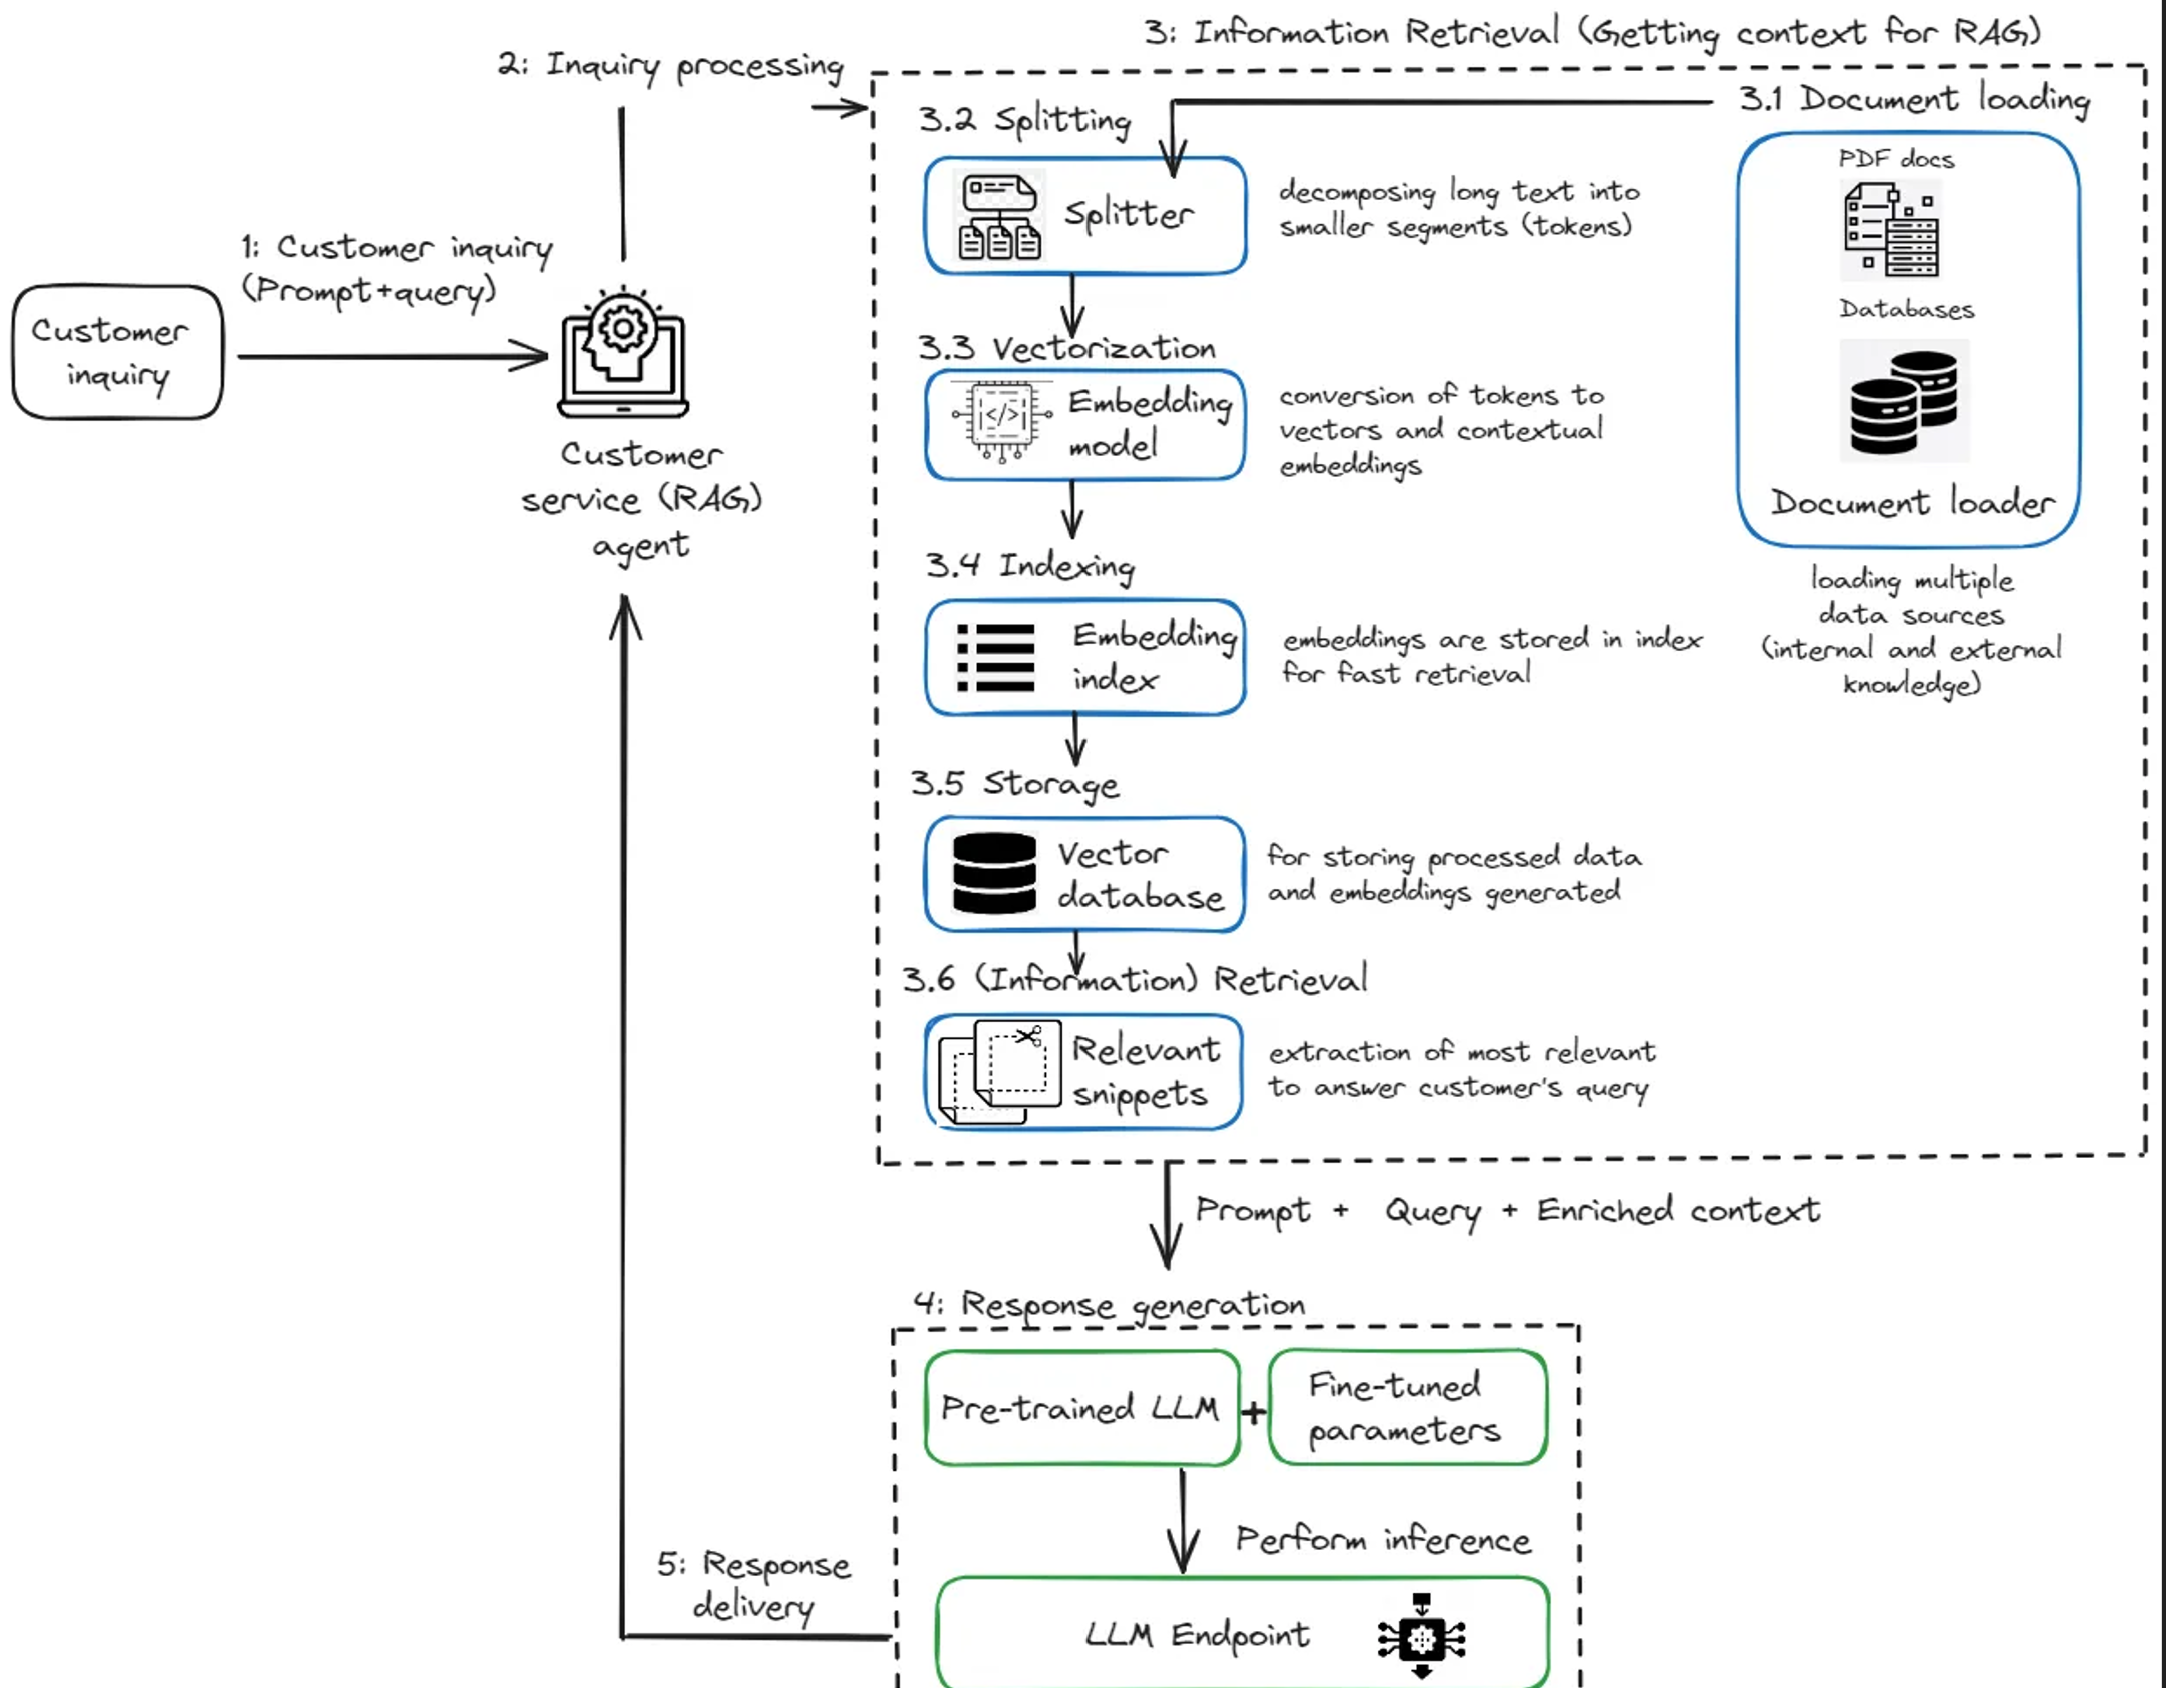

In [45]:
from IPython.display import Image, display

display(Image(filename='images/RAG Architecture Diagram.png'))